## Chicago RRPS Determination
#### First-Choice, Matching Precincts by Voting Patterns

This notebook matches precincts in different cities by the similarity of their voting patterns (their first-choice vote counts for the racial groups available). The end result is a racially-reduced preference schedule of Chicago.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from functools import partial
import pickle
from scipy import spatial
import itertools
import collections

#### Data Processing

The necessary data are:
- Chicago Voting History
- RRPS of Cambridge, Oakland, and Minneapolis

Those data are available in CSVs, and are converted to pandas dataframes below.

In [2]:
def strclean(df):
    """
    Convert all strings in a DataFrame to lowercase, with underscores instead of spaces
    
    df (pandas DataFrame): the DataFrame to be converted
    return: the modified pandas DataFrame
    """
    return df.applymap(lambda x: x.lower().replace(' ', '_') if type(x) == str else x)

In [3]:
# Import Cambridge City Council Data
cambridge_cc2017 = strclean(pd.read_csv('rrps/cambridge_citycouncil_2017rrps.csv', skiprows=1))
cambridge_cc2015 = strclean(pd.read_csv('rrps/cambridge_citycouncil_2015rrps.csv'))
cambridge_cc2013 = strclean(pd.read_csv('rrps/cambridge_citycouncil_2013rrps.csv'))

# Drop unnecessary columns and rename others
# City Council 2017
cambridge_cc2017.drop(columns=['Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31'], inplace=True)
ccc2017_cols = ['id']
ccc2017_cols.extend(['choice' + str(x) for x in range(1, 28)])
cambridge_cc2017.columns = ccc2017_cols

# City Council 2015
cambridge_cc2015.drop(columns=['Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28'], inplace=True)
ccc2015_cols = ['id', 'precinct']
ccc2015_cols.extend(['choice' + str(x) for x in range(1, 24)])
cambridge_cc2015.columns = ccc2015_cols

# City Council 2013
ccc2013_cols = ['id']
ccc2013_cols.extend(['choice' + str(x) for x in range(1, 26)])
cambridge_cc2013.columns = ccc2013_cols

In [4]:
# Import Minneapolis Mayor Data
minneapolis_mayor2017 = strclean(pd.read_csv('rrps/minneapolis_mayor_2017rrps.csv', skiprows=0))
minneapolis_mayor2013 = strclean(pd.read_csv('rrps/minneapolis_mayor_2013rrps.csv', skiprows=0))
minneapolis_mayor2013.head()

# Drop unnecessary columns and rename others
# Mayoral 2017
minneapolis_mayor2017 = minneapolis_mayor2017.filter(['Precinct', 
                                                      '1st Choice_Race', 
                                                      '2nd Choice_Race', 
                                                      '3rd Choice_Race'])
minneapolis_mayor2017.columns = ['precinct', 'choice1', 'choice2', 'choice3']

# Mayoral 2013
minneapolis_mayor2013 = minneapolis_mayor2013.filter(['Precinct', 
                                                      '1ST CHOICE MAYOR MINNEAPOLIS_Race', 
                                                      '2ND CHOICE MAYOR MINNEAPOLIS_Race', 
                                                      '3RD CHOICE MAYOR MINNEAPOLIS_Race'])
minneapolis_mayor2013.columns = ['precinct', 'choice1', 'choice2', 'choice3']

In [5]:
# Import Minneapolis Parks and Recreation Commissioner At Large Data
minneapolis_pal2017 = strclean(pd.read_csv('rrps/minneapolis_parkatlarge_2017rrps.csv', skiprows=0))
minneapolis_pal2013 = strclean(pd.read_csv('rrps/minneapolis_parkatlarge_2013rrps.csv', skiprows=0))

# Drop unnecessary columns and rename others
# Parks and Recreation Commissioner At Large 2017
minneapolis_pal2017 = minneapolis_pal2017.filter(['Precinct', 
                                                  '1st Choice_Race', 
                                                  '2nd Choice_Race', 
                                                  '3rd Choice_Race'])
minneapolis_pal2017.columns = ['precinct', 'choice1', 'choice2', 'choice3']

# Parks and Recreation Commissioner At Large 2013
minneapolis_pal2013 = minneapolis_pal2013.filter(['Precinct',
                                                  '1ST CHOICE PARK AND RECREATION COMMISSIONER AT LARGE MINNEAPOLIS_Race',
                                                  '2ND CHOICE PARK AND RECREATION COMMISSIONER AT LARGE MINNEAPOLIS_Race',
                                                  '3RD CHOICE PARK AND RECREATION COMMISSIONER AT LARGE MINNEAPOLIS_Race'])

minneapolis_pal2013.columns = ['precinct', 'choice1', 'choice2', 'choice3']

#### Chicago Vote History

The data for Chicago's voting history are available in CSVs and are converted to pandas dataframes below.

In [7]:
# Import Chicago Mayoral 2015 Data
chicago_mayor_2015 = pd.read_csv('chicago_vote_history/Chicago_citywide2015.csv', skiprows=0)

In [8]:
# Import Chicago Mayoral 2019 Data
chicago_mayor_2019 = pd.read_csv('chicago_vote_history/Mayoral19_precincts.csv', skiprows=0)

In [9]:
# Reduce the 2015 Mayoral data to the candidates' racial IDs
chicago_mayor_2015['white'] = chicago_mayor_2015['Emanuel_M15'] + chicago_mayor_2015['Fioretti_M15']
chicago_mayor_2015['black'] = chicago_mayor_2015['Wilson_M15'] + chicago_mayor_2015['Walls_M15']
chicago_mayor_2015['hispanic'] = chicago_mayor_2015['Garcia_M15']

chicago_mayor_2015 = chicago_mayor_2015.filter(['ID', 'white', 'black', 'hispanic'])

In [10]:
# Reduce the 2019 Mayoral data to the candidates' racial IDs
chicago_mayor_2019['white'] = chicago_mayor_2019['Joyce'] + chicago_mayor_2019['Daley'] + chicago_mayor_2019['Fioretti'] + chicago_mayor_2019['Kozlar'] + chicago_mayor_2019['McCarth'] + chicago_mayor_2019['Vallas']
chicago_mayor_2019['black'] = chicago_mayor_2019['Enyia'] + chicago_mayor_2019['Ford'] + chicago_mayor_2019['Lightft'] + chicago_mayor_2019['Preckw'] + chicago_mayor_2019['Wilson'] + chicago_mayor_2019['Sal_Grif']
chicago_mayor_2019['hispanic'] = chicago_mayor_2019['Chico'] + chicago_mayor_2019['Mendoza']

chicago_mayor_2019 = chicago_mayor_2019.filter(['JOINID', 'white', 'black', 'hispanic'])
chicago_mayor_2019.columns = ['precinct', 'white', 'black', 'hispanic']

### Data Transformation Functions

The following three functions transform the data into a format amenable to the model.

- precinct_counter: counts the number of first-choice candidates by race in each city
- similarity: pair a precinct in Chicago with similar (voting-wise) precincts in Cambridge and Minneapolis
- permutation_counter: count the choice permutations of the city voting record

In [6]:
def precinct_counter(city_data, city):
    """
    Calculate the number of first choice candidates by race in each
    precinct of a given city.
    
    
    city_data (pandas DataFrame): the city's voting data
    city (str): the abbreviated form of the city name
                Camb = Cambridge, Minn = Minneapolis, Chic = Chicago
    return: a pandas DataFrame with the number of first choice
            candidates by race
    """
    id_var = city_data.columns[0]
    df = city_data.copy(deep=True)
    
    # Create a precinct column
    if city == "Cam":
        df['precinct'] = df[id_var].str[3:6] + df[id_var].str[-1]
    elif city == "Minn":
        df['precinct'] = df[id_var].str[12:]
    elif city == "Chic":
        df.columns[0] = 'precinct'
    
    
    white = df.groupby('precinct')['choice1'].apply(lambda x: x[x == 'white'].count())
    black = df.groupby('precinct')['choice1'].apply(lambda x: x[x == 'black'].count())
    hispanic = df.groupby('precinct')['choice1'].apply(lambda x: x[x == 'hispanic'].count())

    agg_df = pd.concat([white, black, hispanic], axis=1)
    agg_df.columns = ['white', 'black', 'hispanic']
    return agg_df.reset_index()

In [11]:
def similarity(chicago_data, camb_data, minn_data):
    """
    Pair a precinct in Chicago with similar (voting-wise) precincts
    in Cambridge and Minneapolis.
    
    chicago_data (pandas DataFrame): the voting data for Chicago
    camb_data (pandas DataFrame): the voting data for Cambridge
    minn_data (pandas DataFrame): the voting data for Minneapolis
    return: a dictionary mapping Chicago precincts to similar 
            precincts in Cambridge and Minneapolis
    """
    # Initialize a dictionary
    # keys: Chicago precincts
    # values: (P, s)
    # P is a precinct in another city
    # s is the cosine similarity in demographic space
    similarity_dict = {}
    
    # Extract the precinct ID
    c_prec_id = camb_data.columns[0]
    m_prec_id = minn_data.columns[0]
    
    # Count precinct first-choice votes
    cambridge = precinct_counter(camb_data, "Cam")
    minneapolis = precinct_counter(minn_data, "Minn")

    for row in chicago_data.itertuples():
        cam_distpairs = []
        minn_distpairs = []

        for r2 in cambridge.itertuples():
            cam_distpairs.append((list(r2)[1],  1 - spatial.distance.cosine(list(row)[2:], list(r2)[2:])))

        for r2 in minneapolis.itertuples():
            minn_distpairs.append((list(r2)[1],  1 - spatial.distance.cosine(list(row)[2:], list(r2)[2:])))

        # Grab the 5 most similar in Cambridge and the 15 most similar in Minneapolis
        cam_distpairs.sort(key=lambda x: x[1], reverse=True)
        minn_distpairs.sort(key=lambda x: x[1], reverse=True)

        similarity_dict[list(row)[1]] = cam_distpairs[:5] + minn_distpairs[:15]
    
    return similarity_dict

In [12]:
def permutation_counter(city_data, city):
    """
    Count the choice permutations of the city voting record.
    
    city_data (pandas DataFrame): the voting data for the city
    city (str): the abbreviated form of the city name
                Camb = Cambridge, Minn = Minneapolis, Chic = Chicago
    return: a Counter dictionary for every permutation in 
            every precinct
    """
    # Extract the precinct ID
    id_var = city_data.columns[0]
    
    df = city_data.copy(deep=True)
    results = collections.defaultdict(list)
    
    # Create a precinct column
    if city == "Cam":
        df['precinct'] = df[id_var].str[3:6] + df[id_var].str[-1]
        if id_var != 'precinct':
            df.drop(columns=[id_var], inplace=True)
    elif city == "Minn":
        df['precinct'] = df[id_var].str[12:]
        if id_var != 'precinct':
            df.drop(columns=[id_var], inplace=True)
    elif city == "Chic":
        df.columns[0] = 'precinct'
        if id_var != 'precinct':
            df.drop(columns=[id_var], inplace=True)
    
    # Record the permutations
    for row in df.itertuples():
        results[getattr(row, 'precinct')].append(tuple([s for s in list(row)[2:5]]))
    
    # Count occurrences
    for k,v in results.items():
        results[k] = collections.Counter(v)
    
    # Remove empty votes
    # Think about NaNs
    for k, v in results.items():
        if v == []:
            print("remove")
            results.pop(k, None)
        
    return results

### The Model

The model below is the first-choice distribtuion model with precinct matching by first-choice voting patterns.

In [13]:
def fcpm(chicago_data, camb_data, minn_data):
    """
    Return the first-choice distribution (precinct matching method)
    of Chicago based on Cambridge and Minneapolis data.
    
    chicago_data (pandas DataFrame): Chicago vote history
    camb_data (pandas DataFrame): the voting data for Cambridge
    minn_data (pandas DataFrame): the voting data for Minneapolis
    
    return: a dictionary of Chicago voting, in permutation counts
    """
    chic_impute = collections.defaultdict(dict)
    
    # Format the data
    chic_dict = similarity(chicago_data, camb_data, minn_data)
    minn_prec_votes = permutation_counter(minn_data, "Minn")
    camb_prec_votes = permutation_counter(camb_data, "Cam")
    
    # For each precinct in chicago
    for prec in chic_dict.keys():
        # For each match precint P in that dictionary
        for match in chic_dict[prec]:
            # Use the weight s on P times the percentage of
            # people in P voting each preference schedule
            # and sum, then normalize so that the total
            # votes is equal to VAP
            
            # Separate Minneapolis from Cambridge
            # Minneapolis precincts start with 'w'
            if match[0][0] == 'w':
                for k, v in minn_prec_votes[match[0]].items():
                    if k in chic_impute[prec].keys():
                        chic_impute[prec][k] += v * match[1] ** 1
                    else:
                        chic_impute[prec][k] = v * match[1] ** 1
            else:
                for k, v in camb_prec_votes[match[0]].items():
                    if k in chic_impute[prec].keys():
                        chic_impute[prec][k] += v * match[1] ** 1
                    else:
                        chic_impute[prec][k] = v * match[1] ** 1
    
    # Normalize the data by the voting age population
    df_chic_demo = pd.read_csv('match_data/chicago_prec_demo.csv',index_col=0).dropna()
    
    for k, v in chic_impute.items():
        tot = sum(list(v.values()))
        for k2 in v.keys():
            index = int(k[1:])
            vap = df_chic_demo.loc[index]['VAP']
            v[k2] = v[k2] / tot * vap
        
    return chic_impute

In [14]:
# Run the model
chic_results = vrfp(chicago_mayor_2019, cambridge_cc2017, minneapolis_mayor2017)

/Users/hakeemangulu/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


### Data Summarization and Analysis

In [16]:
# Summarise the data
totvots = collections.defaultdict(float)

# Gather the total votes
for v in chic_results.values():
    for k2, v2 in v.items():
        totvots[k2] = np.nansum([totvots[k2], v2])

races = ['white', 'black', 'hispanic', 'asian', 'undetermined']

# Go through each race and count the votes
for r in races:
    total = 0
    for k, v in totvots.items():
        if k[0] == r:
            total = np.nansum([total, v])
    print("1st Choice {}: {}".format(r, total))
        
for r in races:
    total = 0
    for k, v in totvots.items():
        if r in k:
            total = np.nansum([total, v])
    print("{} in top 3: {}".format(r, total))

1st Choice white: 1208313.4495322995
1st Choice black: 617478.1171670462
1st Choice hispanic: 0
1st Choice asian: 144211.9349578325
1st Choice undetermined: 2430.6789432948854
white in top 3: 1782126.139626586
black in top 3: 1187598.3463537283
hispanic in top 3: 0
asian in top 3: 382147.1388145804
undetermined in top 3: 14049.998020998308


In [76]:
# Convert the results to a DataFrame
df = pd.DataFrame.from_dict(chic_results, orient='index')
old_cols = df.columns
new_cols = []
for col_name in old_cols:
    abbrev = ''
    for race in col_name:
        if type(race) == str:
            abbrev += race[0]
        else:
            abbrev += 'U' 
    new_cols.append(abbrev.upper())
df.columns = new_cols

# Fill NaNs and combine duplicated columns
df = df.fillna(0)
df = df.groupby(df.columns, axis=1).sum()

# Sort the columns
df = df.reindex(sorted(df.columns), axis=1)

In [77]:
# Save the results to a CSV
df.to_csv('rrps_results/fcpm/minn_camb_2017.csv')

### Brief Comparison with Precinct Matching by Demographic

The following figures compare the first-choice precinct matching (FCPM) model with the voter-race precinct matching (VRPM) model.

In [25]:
first_choice_votes = [1208313.4495322995, 617478.1171670462, 0, 144211.9349578325, 144211.9349578325]
first_choice_demo = [1544285.2855284999, 459879.6702216003, 0, 93912.52588821895, 93912.52588821895]

three_choice_votes = [1782126.139626586, 1187598.3463537283, 0, 382147.1388145804, 14049.998020998308]
three_choice_demo = [1972033.456538633, 1076221.3580279176, 0, 268800.35078889976, 15347.242811505115]

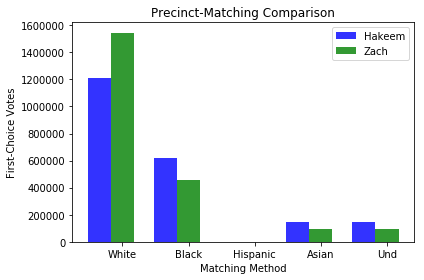

In [19]:
n_groups = 5
 
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, first_choice_votes, bar_width,
alpha=opacity,
color='b',
label='Hakeem')
 
rects2 = plt.bar(index + bar_width, first_choice_demo, bar_width,
alpha=opacity,
color='g',
label='Zach')
 
plt.xlabel('Matching Method')
plt.ylabel('First-Choice Votes')
plt.title('Precinct-Matching Comparison')
plt.xticks(index + bar_width, ('White', 'Black', 'Hispanic', 'Asian', 'Und'))
plt.legend()
 
plt.tight_layout()
plt.show()

In [29]:
races = ['White', 'Black', 'Asian', 'Undetermined']
pct_diff = collections.defaultdict(float)

for i in range(len(first_choice_votes)):
    if first_choice_votes[i] == 0 or first_choice_demo[i] == 0:
        continue
    pct_diff[races[i]] = (first_choice_votes[i] / first_choice_demo[i])

defaultdict(float,
            {'white': 0.7824418589333247,
             'black': 1.3426949638141312,
             'asian': 1.5355985114220367,
             'undetermined': 1.5355985114220367})

In [31]:
[v for k, v in pct_diff.items()]

[0.7824418589333247,
 1.3426949638141312,
 1.5355985114220367,
 1.5355985114220367]

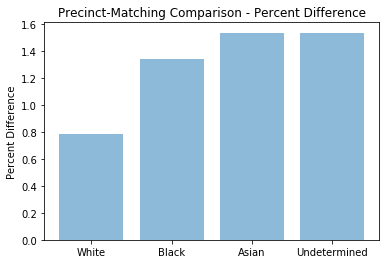

In [34]:
races = ['White', 'Black', 'Asian', 'Undetermined']
list_rep = [v for k, v in pct_diff.items()]

y_pos = np.arange(len(races))
x = list_rep
 
plt.bar(y_pos, x, align='center', alpha=0.5)
plt.xticks(y_pos, races)
plt.ylabel('Percent Difference')
plt.title('Precinct-Matching Comparison - Percent Difference')
 
plt.show()